# Demo using CVAE on CORE2 data
This is based on an example from Keras.io by fchollet.  Please see last cell for original code and links.

# Conda env setup
The following packages need to be installed in the following order on top of a typical base Conda env:
```bash
conda install -y -c conda-forge tensorflow
conda install -y -c conda-forge netCDF4          # For reading nc files
conda install -y -c conda-forge cartopy          # For making maps
conda install -y -c conda-forge matplotlib
conda install -y -c conda-forge pandas
conda install -y -c conda-forge cdo              # For converting grib to nc

# conda install -y -c conda-forge scikit-learn
# conda install -y -c dask                         # Needed for pynio (but not explicitly listed in req's!)
```

# Download and convert data
On my [first Google hit for GEFS](https://www.ncei.noaa.gov/products/weather-climate-models/global-ensemble-forecast), I clicked on [AWS Open Data Registry for GEFS](https://registry.opendata.aws/noaa-gefs-pds/) and selected [NOAA GEFS Re-forecast](https://registry.opendata.aws/noaa-gefs-reforecast/) which has no useage restrictions.  The [GEFS Re-forecast data documentation](https://noaa-gefs-retrospective.s3.amazonaws.com/Description_of_reforecast_data.pdf) is very clear and we're going to download two files, 57 MB each.  The date of the initialization of the re-forecast is in the file name in the format YYYYMMDDHH.  The c00, p01, p02, p03, p04 are the control and perturbation ensemble members (5 total).

In [1]:
data_prefix = "./gefs_data"

In [2]:
!wget -q -P {data_prefix} https://noaa-gefs-retrospective.s3.amazonaws.com/GEFSv12/reforecast/2019/2019010100/c00/Days%3A1-10/pres_sfc_2019010100_c00.grib2

In [3]:
!wget -q -P {data_prefix} https://noaa-gefs-retrospective.s3.amazonaws.com/GEFSv12/reforecast/2019/2019010200/c00/Days%3A1-10/pres_sfc_2019010200_c00.grib2

In [4]:
!csh batch_grib2nc.csh

Working on ./gefs_data/pres_sfc_2019010100_c00.grib2
cdo    copy:   1cdo    copy: Processed 83059200 values from 1 variable over 80 timesteps [4.18s 83MB]
Working on ./gefs_data/pres_sfc_2019010100_c00.grib2.1
cdo    copy:   1cdo    copy: Processed 83059200 values from 1 variable over 80 timesteps [3.71s 83MB]
Working on ./gefs_data/pres_sfc_2019010100_c00.grib2.1.nc
cdo    copy:                  1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6 7 7 7 7 7 7 7 7 8 8 8 8 8 8 8 8 9 9 9 9 9 9 9 91cdo    copy: Processed 83059200 values from 1 variable over 80 timesteps [0.46s 49MB]
Working on ./gefs_data/pres_sfc_2019010100_c00.grib2.2
cdo    copy:   1cdo    copy: Processed 83059200 values from 1 variable over 80 timesteps [1.82s 83MB]
Working on ./gefs_data/pres_sfc_2019010100_c00.nc
cdo    copy:                  1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6 7 7 7 7 7 7 7 7 8 8 8 8 8 8 8 8 9 9 9

# Libraries

In [11]:
import os, json

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import tensorflow as tf
import netCDF4
import cartopy

from tensorflow import keras
from keras import layers
#from sklearn.model_selection import train_test_split

# Load and preprocess the training data
The standard way of manipulating arrays in Conv2D layers in TF is to use arrays in the shape:
`batch_size,  height, width, channels = data.shape`
In our case, the the `batch_size` is the number of image frames (i.e. separate samples or rows in a `.csv` file), the `height` and `width` define the size of the image frame in number of pixels, and the `channels` are the number of layers in the frames.  Typically, channels are color layers (e.g. RGB or CMYK) but in our case, we could use different metereological variables.  However, for this first experiment, **we only need one channel** because we're only going to use sea level pressure (SLP).

The code for loading GEFS `.grib` files and making an initial plot is from [Victor Gensini's example](https://github.com/vgensini/gefs_v12_example/blob/master/GEFS_v12_eample.ipynb) posted on the GEFS Open Data Registry landing page.

In [6]:
# Load data
dat_dir = "/home/lobielodan/parsl_mpi/run_on_cluster/cvae-weather-ensemble/gefs_data/"
dataset = netCDF4.Dataset(dat_dir + "pres_sfc_2019010100_c00.nc")

In [7]:
# Look at data structure
print(dataset)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_64BIT_OFFSET data model, file format NETCDF3):
    CDI: Climate Data Interface version 2.4.1 (https://mpimet.mpg.de/cdi)
    Conventions: CF-1.6
    history: Mon Jun 24 20:04:59 2024: cdo -f nc copy ./gefs_data/pres_sfc_2019010100_c00.grib2 ./gefs_data/pres_sfc_2019010100_c00.nc
    CDO: Climate Data Operators version 2.4.1 (https://mpimet.mpg.de/cdo)
    dimensions(sizes): time(80), lon(1440), lat(721)
    variables(dimensions): float64 time(time), float64 lon(lon), float64 lat(lat), float32 sp(time, lat, lon)
    groups: 


In [8]:
# Example for simple data access
print(dataset.variables.keys())

for var in dataset.variables:
    print(dataset.variables[var])
    print(dataset.variables[var][:])

dict_keys(['time', 'lon', 'lat', 'sp'])
<class 'netCDF4._netCDF4.Variable'>
float64 time(time)
    standard_name: time
    units: hours since 2019-1-1 00:00:00
    calendar: proleptic_gregorian
    axis: T
unlimited dimensions: time
current shape = (80,)
filling on, default _FillValue of 9.969209968386869e+36 used
[  3.   6.   9.  12.  15.  18.  21.  24.  27.  30.  33.  36.  39.  42.
  45.  48.  51.  54.  57.  60.  63.  66.  69.  72.  75.  78.  81.  84.
  87.  90.  93.  96.  99. 102. 105. 108. 111. 114. 117. 120. 123. 126.
 129. 132. 135. 138. 141. 144. 147. 150. 153. 156. 159. 162. 165. 168.
 171. 174. 177. 180. 183. 186. 189. 192. 195. 198. 201. 204. 207. 210.
 213. 216. 219. 222. 225. 228. 231. 234. 237. 240.]
<class 'netCDF4._netCDF4.Variable'>
float64 lon(lon)
    standard_name: longitude
    long_name: longitude
    units: degrees_east
    axis: X
unlimited dimensions: 
current shape = (1440,)
filling on, default _FillValue of 9.969209968386869e+36 used
[0.0000e+00 2.5000e-01 5.0

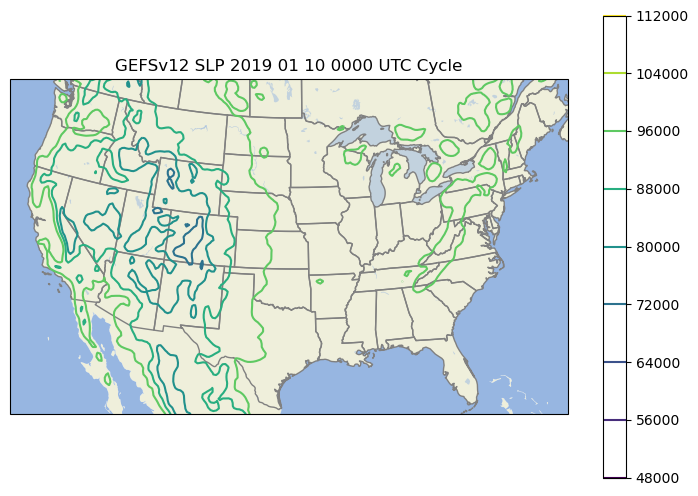

In [9]:
# Example for plot
fig = plt.figure(figsize=(9,6))
ax = plt.axes(projection = cartopy.crs.LambertConformal())
ax.add_feature(cartopy.feature.LAND)
ax.add_feature(cartopy.feature.OCEAN)
ax.add_feature(cartopy.feature.LAKES, alpha = 0.5)
ax.add_feature(cartopy.feature.STATES, edgecolor='grey')
plt.contour(
    dataset.variables['lon'][:], # longitudes
    dataset.variables['lat'][:], # latitudes
    dataset.variables['sp'][0,:,:],# actual data
    transform = cartopy.crs.PlateCarree())#, levels=np.arange(30000,110000,20000))
plt.title('GEFSv12 SLP 2019 01 10 0000 UTC Cycle')
ax.set_extent([-120, -73, 23, 50])
plt.colorbar()
plt.show()

In [ ]:
# Use MNIST data preproc as template
many_time_steps = False
if many_time_steps:
    slp = np.expand_dims(
        np.concatenate(
            [slp_01_ds.PRES_P1_L1_GLL0.values,
             slp_02_ds.PRES_P1_L1_GLL0.values],
            axis=0),
        -1).astype("float32") / 110000
else:
    slp = np.expand_dims(
        slp_01_ds.PRES_P1_L1_GLL0.values,
        -1).astype("float32") / 110000

In [ ]:
# Verify data size
np.shape(slp)

# Create sampling layer

In [ ]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# Build the encoder
GFS grids I have available here are at 0.25 degree resolution.  I'm doing this as a "worst case" scenario since there are also 0.5 and 1.0 degree grids with lower resolution but I can't find that data quickly and don't know what's available.

These 0.25 degree grids are 721 x 1440.
Each forecast file is 3 hourly for 10 days = 8 steps/forecast * 10 days = 80 "frames"
This demo is only using two forecasts from the control ensemble
(one launched Jan 01, 2019 and one launched Jan 02, 2019) -> this is only 
a small subset of the variability possible in the model.

This particular data set spans 2000-2019 and there are 5 ensemble members.

___

## Neural network design

We need to get to a small latent space and conv2D networks are good because they help reduce the number of connections in a network in a meaningful way.  I'm using terms as defined in [this definition of conv2D](https://towardsdatascience.com/conv2d-to-finally-understand-what-happens-in-the-forward-pass-1bbaafb0b148).

Filter options:
Longitude is easy because it is large and even, so as long as you have an even stride, you get integer results when dividing.
e.g. lon 9, stride 4, lat 7, stride 5

- Latitude - even numbers occurr for P = 2, K = 3 or K = 11.
- 11 grid points * 0.25deg * 100km/deg = 275 km filter window, which is a good scale for weather.
- 9 grid points * 0.25 * 100km/deg = 225 km
- Longitude - even numbers occur for P = 0, K = 11 (nice match with Latitude), P = 1, K = 3 or 13, P = 2, K = 5.
For a 5x7 filter with 3 stride (no overlap) and no padding,
- lat: (721 - 4)/3 = 239 possible steps (good even number!)
- lon: (1440 - 4)/3 = 478.6666 possible steps

In [ ]:
# Try different filter sizes
# Aim for large initial filter > 200km scale (about 10)
# Aim for some, but minimal overlap in initial filter.

# Aim for smallish second filter, but still try to reduce dimensionality
# to make dense network tractable later.  No overlap (but no good
# reason why this is).

#----------------------Input: 721x1440--------------

# For Lat = 721,
# K = 11 -> K_radius = 5.0 -> S = 9 -> H_out = 79.0

# For Lon = 1440,
# K = 11 -> K_radius = 5.0 -> S = 10 -> H_out = 143.0

#-----------------------Layer1: 79x143----------------

# For Lat = 79,
# K = 5 -> K_radius = 2.0 -> S = 5 -> H_out = 15.0

# For Lon = 143,
# K = 9 -> K_radius = 4.0 -> S = 9 -> H_out = 15.0

H_in = 1440
P = 0
K_list = [3, 5, 7, 9, 11, 13, 15]         # Kernel size
S_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
for K in K_list:
    for S in S_list:
        K_radius = np.floor(np.divide(K,2))   # Half width of number of points around the central point
        K_diameter = K - 1                    # Number of points around the central point, ASSUMES K = ODD
        #S = K                 # S = K is stride necessary to have non-overlapping filters
        print('K = '+str(K)+' -> K_radius = '+str(K_radius)+' -> S = '+str(S)+' -> H_out = '+str((H_in + 2*P - K_diameter)/S))

In [ ]:
def build_encoder(latent_dim):
    encoder_inputs = keras.Input(shape=(721, 1440, 1))
    x = layers.Conv2D(32, 11, activation="relu", strides=[9,10], padding="valid")(encoder_inputs)
    x = layers.Conv2D(64, [5,9], activation="relu", strides=[5,9], padding="valid")(x)
    x = layers.Flatten()(x)
    x = layers.Dense(16, activation="relu")(x)
    z_mean = layers.Dense(latent_dim, name="z_mean")(x)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
    z = Sampling()([z_mean, z_log_var])
    encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
    print(encoder.summary())
    return encoder

# Build the decoder

With the 11x11 and 5x5 filters, non-overlapping stride, applied here, we have a final "image" size of 14 x 27 and 64 channels.

In [ ]:
# Why 7x7x64?
# 7 x 7 "image" remaining after two conv2D operations x 64 filters/channels

In [ ]:
def build_decoder(latent_dim):
    latent_inputs = keras.Input(shape=(latent_dim,))
    x = layers.Dense(15 * 15 * 64, activation="relu")(latent_inputs)
    x = layers.Reshape((15, 15, 64))(x)
    # FIXME - there is something wrong here, but at least there is a pattern.
    # Using output_padding as a fudge factor -> it may be that there is exactly
    # one "missing" filter stamp/convolution because for both Conv2DTranspose
    # operations, output_padding is set to maximum it could be in both dims
    # (i.e. exactly one less than the stride of each filter).
    x = layers.Conv2DTranspose(64, [5,9], activation="relu", strides=[5,9], padding="valid", output_padding=[4,8])(x)
    x = layers.Conv2DTranspose(32, 11, activation="relu", strides=[9,10], padding="valid", output_padding=[8,9])(x)
    decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
    decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
    print(decoder.summary())
    return decoder

# Define the VAE as a `Model` with a custom `train_step`

In [ ]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            # FIXME: Normalize loss with the number of features (28*28)
            n_features = 28*28
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )/n_features
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))/n_features
            total_loss = (reconstruction_loss + kl_loss)
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    # Needed to validate (validation loss) and to evaluate
    def test_step(self, data):
        if type(data) == tuple:
            data, _ = data
            
        z_mean, z_log_var, z = self.encoder(data)
        reconstruction = self.decoder(z)
        # FIXME: Normalize loss with the number of features (28*28)
        n_features = 28*28
        reconstruction_loss = tf.reduce_mean(
            tf.reduce_sum(
                keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
            )
        )/n_features
        kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))/n_features
        total_loss = (reconstruction_loss + kl_loss)
        #grads = tape.gradient(total_loss, self.trainable_weights)
        #self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

# Helper functions

In [ ]:
# Only works if latent_dim = 2
def plot_latent_space(vae, n=30, figsize=15, show = False, path = ''):
    # display a n*n 2D manifold of digits
    digit_size = 28
    scale = 1.0
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = vae.decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    if show:
        plt.show()
    if path:
        plt.savefig(path)

def plot_images(images, rows, columns, show = False, path = ''):
    fig = plt.figure(figsize = (10, 7))
    
    for i, image in enumerate(images):
        fig.add_subplot(rows, columns, i+1)
        plt.imshow(image, cmap = 'binary')
        plt.axis('off')

    if show:
        plt.show()
    if path:
        plt.savefig(path)
    
def load_fashion_mnist():
    fashion_mnist = keras.datasets.fashion_mnist
    (X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
    fashion_mnist = np.concatenate([X_train, X_test], axis=0)
    fashion_mnist = np.expand_dims(fashion_mnist, -1).astype("float32") / 255
    X_train, X_test = train_test_split(fashion_mnist)
    X_train, X_valid = train_test_split(X_train)
    return X_train, X_valid, X_test

def load_digits_mnist():
    (x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
    mnist_digits = np.concatenate([x_train, x_test], axis=0)
    mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255
    X_train, X_test = train_test_split(mnist_digits)
    X_train, X_valid = train_test_split(X_train)
    return X_train, X_valid, X_test

# Train the VAE

In [ ]:
# Used this original code as template for data concatenation/preproc
#(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
#mnist_digits = np.concatenate([x_train, x_test], axis=0)
#mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255
#vae = VAE(encoder, decoder)
#vae.compile(optimizer=keras.optimizers.Adam())
#vae.fit(mnist_digits, epochs=30, batch_size=128)

latent_dim = 2
train = True
model_dir = './model_dir'

os.makedirs(model_dir, exist_ok = True)
    
X_train, X_valid, X_test = load_fashion_mnist()
    
encoder = build_encoder(latent_dim)
decoder = build_decoder(latent_dim)
vae = VAE(encoder, decoder)
#vae.compile(optimizer=keras.optimizers.Adam())
vae.compile(optimizer = 'rmsprop')

# FIXME: change out data sets, very small training set!
X_train = slp[0:40,:,:,:]
X_valid = slp[41:61,:,:,:]
X_test = slp[62:79,:,:,:]
if train:
    early_stopping_cb = keras.callbacks.EarlyStopping(patience = 5, restore_best_weights = True)
    history = vae.fit(
        X_train, epochs = 50, batch_size = 128,
        callbacks = [early_stopping_cb],
        validation_data = (X_valid,)
    )
    vae.save_weights(os.path.join(model_dir, 'vae'))
    hist_pd = pd.DataFrame(history.history)
    hist_pd.to_csv(os.path.join(model_dir, 'history.csv'), index = False)
    test_loss = vae.evaluate(X_test)
    test_loss = dict(zip(["loss", "reconstruction_loss", "kl_loss"], test_loss))
    print('Test loss:')
    print(test_loss)
    with open(os.path.join(model_dir, 'test_loss.json'), 'w') as json_file:
        json.dump(test_loss, json_file, indent = 4)
            
else:
    vae.load_weights(os.path.join(model_dir, 'vae'))

if latent_dim == 2:
    plot_latent_space(vae, path = os.path.join(model_dir, 'latent_space.png'))

# Generating new images
codings = tf.random.normal(shape = [12, latent_dim])
images = vae.decoder(codings).numpy()
plot_images(images, 3, 4, path = os.path.join(model_dir, 'generated.png'))

# Semantic interpolation
codings_grid = tf.reshape(codings, [1, 3, 4, latent_dim])
larger_grid = tf.image.resize(codings_grid, size = [5, 7])
interpolated_codings = tf.reshape(larger_grid, [-1, latent_dim])
images = vae.decoder(interpolated_codings).numpy()
plot_images(images, 5, 7, path = os.path.join(model_dir, 'interpolated.png'))

# Display a grid of sampled digits

In [ ]:
def plot_latent_space(vae, n=30, figsize=15):
    # display a n*n 2D manifold of digits
    digit_size = 28
    scale = 1.0
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = vae.decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent_space(vae)

# Display how the latent space clusters different digit classes

In [ ]:
def plot_label_clusters(vae, data, labels):
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = vae.encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()


(x_train, y_train), _ = keras.datasets.mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255

plot_label_clusters(vae, x_train, y_train)

# Original code
CVAE example from [Keras.io](https://keras.io/examples/generative/vae/), [github repo](https://github.com/keras-team/keras-io/blob/master/examples/generative/vae.py).

```python
"""
Title: Variational AutoEncoder
Author: [fchollet](https://twitter.com/fchollet)
Date created: 2020/05/03
Last modified: 2020/05/03
Description: Convolutional Variational AutoEncoder (VAE) trained on MNIST digits.
"""

"""
## Setup
"""

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

"""
## Create a sampling layer
"""


class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


"""
## Build the encoder
"""

latent_dim = 2

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

"""
## Build the decoder
"""

latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

"""
## Define the VAE as a `Model` with a custom `train_step`
"""


class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }


"""
## Train the VAE
"""

(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255

vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(mnist_digits, epochs=30, batch_size=128)

"""
## Display a grid of sampled digits
"""

import matplotlib.pyplot as plt


def plot_latent_space(vae, n=30, figsize=15):
    # display a n*n 2D manifold of digits
    digit_size = 28
    scale = 1.0
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = vae.decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent_space(vae)

"""
## Display how the latent space clusters different digit classes
"""


def plot_label_clusters(vae, data, labels):
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = vae.encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()


(x_train, y_train), _ = keras.datasets.mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255

plot_label_clusters(vae, x_train, y_train)
```